In [5]:
import geopandas as gpd
import fiona
from shapely.geometry import Point, MultiPoint
import geoplot
import networkx as nx
from shapely.geometry import LineString
import geoplot.crs as gcrs
import os

os.chdir('CO2JRC_OpenFormats/CO2Stop_Polygons Data/')

# Useful data tables:
    capacity data: 
     - formation: CO2Stop_DataInterrogationSystem/Hydrocarbon_Formations.csv
     - storage_unit: CO2Stop_DataInterrogationSystem/Hydrocarbon_Storage_Units.csv
     - HC fields (gas or oil field used to store co2): CO2Stop_DataInterrogationSystem/Hydrocarbon_Traps_Temp.csv, Hydrocarbon_Traps.csv,  Hydrocarbon_Traps1.csv
     - country level capacity: Total_Storage_Cap_Aquif_HCFields.csv
     - other dataset: nothing useful about capacity ,but could be use to set custom Constraints for capacity estimation
     #
     #
     map data:
     - Formations2_March12.kml: only formation data we have
     - StorageUnits_March13.kml: have more polygons than StorageUnits_March12.kml
     - Daughter_Unit_March13.kml
     
     Polygons' size become smaller and samller from formation level to storage level

In [6]:
from shapely.geometry import Point
import geopandas as gpd
import pandas as pd
import re
from pandas_profiling import ProfileReport
def load2geodf(Path = '../CO2Stop_DataInterrogationSystem/Hydrocarbon_Formations.csv'):
    f = pd.read_csv(Path)
    f['geometry'] = f.apply(lambda x: Point((x['X'],x['Y'])),axis=1)
    f = gpd.GeoDataFrame(f,crs = 'EPSG:23032')
    candidate = [] 
    for i in f.columns:
        if re.search('cap',i.lower()):
            candidate.append(i)
    return f,candidate

In [7]:
trap,trap_cap = load2geodf('../CO2Stop_DataInterrogationSystem/Hydrocarbon_Traps.csv')
trap2,trap2_cap = load2geodf('../CO2Stop_DataInterrogationSystem/Hydrocarbon_Traps1.csv')
trap_tmp,trap_tmp_cap = load2geodf('../CO2Stop_DataInterrogationSystem/Hydrocarbon_Traps_Temp.csv')
storage_unit,su_cap = load2geodf('../CO2Stop_DataInterrogationSystem/Hydrocarbon_Storage_Units.csv')
formation,formation_cap = load2geodf('../CO2Stop_DataInterrogationSystem/Hydrocarbon_Formations.csv')

# chaos of coordinate system

In [11]:
trap_all = pd.concat([trap,trap2,trap_tmp]).drop_duplicates()

In [190]:
trap.Projection_Info.unique() EPSG:4326

array([nan, 'lambert', 'Lambert', 'Lamberts', 'lamberts',
       'NTF_Lambert_II_Carto', 'ETRS_1989_UTM_Zone_33N',
       'Belgian date 72, Lambert 72', 'Belgian date 72, Lambert 1972',
       'LAMBERT CONFORMAL CONIC - Project Projection',
       'S-JTSK_Krovak_East_North', 'LAMBERT CONFORMAL CONIC- GeoCapacity',
       'LAMBERT CONFORMAL CONIC',
       'LAMBERT CONFORMAL CONIC- EU GeoCapacity', 'EOV',
       'TM65 Irish Grid', 'x: long - y: lat - WGS84',
       'x: longitude - y: latitude (WGS84)', 'WGS-84', 'GCS-WGS-84',
       'Macedonian Transverse Mercator', 'ED_1950_UTM_Zone_31N',
       'Lambert Conformal Conical of the WGS84 ellipsoid',
       'Rectangular coordinates 1942 system', 'Pulkovo 1942 - Zone 34',
       'Pulkovo 1942 - Zone 33', 'UTM35N', 'WGS84 UTM31N'], dtype=object)

In [194]:
storage_unit.Projection_Info.unique()

array(['ED_1950_UTM_Zone_30N', nan,
       'LAMBERT CONFORMAL CONIC - Project Projection',
       'LAMBERT CONFORMAL CONIC- GeoCapacity',
       'LAMBERT CONFORMAL CONIC- EU GeoCapacity',
       'LAMBERT CONFORMAL CONIC', 'EOV', 'TM65 Irish Grid',
       'x: long - y: lat - WGS84', 'ETRS_1989_UTM_Zone_33N',
       'Belgian datum 72, Lambert 1972', 'WGS 84', 'WGS84',
       'S-JTSK_Krovak_East_North', 'Decimal degrees', 'Decimal Degrees',
       'WGS-84', 'GCS-WGS-84', 'Macedonian Transverse Mercator',
       'ED_1950_UTM_Zone_31N', ' Pulkovo 1942 - Zone 34',
       'Pulkovo 1942 - Zone 34', 'Nord_Maroc_Degree', 'UTM35N',
       'Slovenian Gauss Kruger', 'Gauss-Kruger coordinate system',
       'Lambert conformal conic', 'WGS84 UTM31N', 'WGS84 UTM31'],
      dtype=object)

In [195]:
formation.Projection_Info.unique()

array(['ETRS_1989_UTM_Zone_33N', 'Belgian datum 72, Lambert 1972',
       'WGS 84', 'LAMBERT CONFORMAL CONIC - Project Projection', 'WGS84',
       'S-JTSK_Krovak_East_North', nan, 'Decimal degrees',
       'ED_1950_UTM_Zone_30N', 'TM65 Irish Grid',
       'x: long - y: lat - WGS84', 'x: longitude - y: latitude (WGS84)',
       'WGS-84', 'GCS-WGS-84', 'Macedonian Transverse Mercator',
       'ED_1950_UTM_Zone_31N', 'Pulkovo 1942 - Zone 34', 'UTM35N',
       'Gauss-Kruger', 'unknown projection', 'Unknown Projection',
       'Lambert conformal conic', 'WGS84 UTM31N'], dtype=object)

## about capacity dataset
**Here we can see that, even though we have exact coordinate of each trap unit, however we can't use them, because so chaos coordinate reference system (CRS).**
- too many different CRS in projection info (Details of projection used for X and Y co-ords)
- many projection info like "lambert", "Lambert" make no sense, because there are 30+ EPSG CRS have something to do with lambert. Even search with "lambert Denmark" still can't find the answer
- I have tried to match the coordinates to a known CRS, however i still can't find an appropriate CRS for points in Denmark. 

**formation is the biggest concept of a co2 storage, it consists of two type co2 storage**
- this means capacity(formation) = sum(capacity(storage unit)) = sum(capacity(aquifer daughter unit))+ sum(capacity(HC fields))
- capacity of formation is also called TASR (Technically accessible storage reserve)
**In this dataset two type of co2 storage (daughter unit) are considered**
- this two tpye storage separately correspond to "storage_unit" table and "trap" table

**There are several different capacity (min mean max capacities, capacities entered by each country, min mean max capacities estimated by author), as the author argue that, most TASR are overestimated, i suggest to choose mean capacity**


## about matching capacity to polygons:
**i suggest not to consider formation vector map. Instead I only use storage units**
- because formation consists of storage units   -------- p6: 2.3 CO2 Storage resource assessment in CO2StoP  -- daughter units is where co2 will physically be stored however the matching result between daughter units and trap table is worse than storage unit level
- because high percentage verlap between formation map and storage unit map
- because storage unit map has more detail (a lot of samller polygons) (storage unit in Italy)

**I suggest first match storage unit table to daughter map**
**subtract matched capacity of daughter unit from  country capacity in country table**
**After that based on polygons' size allocate rest co2 storage capacity of each country**
**!!!!!! but if we can solve the coordinate system problem, we don't even need matching process. Or we can based on coordinate to match**



--Lisa


## Unit:
**Mt** -----------p47 "Maximum estimated CO2 storage capacity (Mt) – aquifer daughter unit only"


#  quite a lot capacity estimation
#  too many missing value (0)

In [229]:
trap[trap2_cap].head()
#MEAN_EST_STORE_CAP_GAS
#MEAN_EST_STORE_CAP_OIL

EST_STORECAP_MIN  EST_STORECAP_MEAN  EST_STORECAP_MAX CAP_EST_METHOD  \
0               0.0                0.0               0.0            NaN   
1               0.0                0.0               0.0            NaN   
2               0.0                0.0               0.0            NaN   
3               0.0                0.0               0.0            NaN   
4               0.0                0.0               0.0            NaN   

   MIN_EST_STORE_CAP_GAS  MEAN_EST_STORE_CAP_GAS  MAX_EST_STORE_CAP_GAS  \
0                    0.0                     8.6                    0.0   
1                    0.0                    44.3                    0.0   
2                    0.0                     9.8                    0.0   
3                    0.0                     8.7                    0.0   
4                    0.0                   152.3                    0.0   

   MIN_EST_STORE_CAP_OIL  MEAN_EST_STORE_CAP_OIL  MAX_EST_STORE_CAP_OIL  ...  \
0                    0.0                     0.0                    0.0  ...   
1                    0.0                     0.0                    0.0  ...   
2                    0.0                     0.0                    0.0  ...   
3                    0.0                     0.0                    0.0  ...   
4                    0.0                     0.0                    0.0  ...   

   MEAN_CALC_STORE_CAP_GAS  MAX_CALC_STORE_CAP_GAS  MIN_CALC_STORE_CAP_OIL  \
0                      0.0                     0.0                     0.0   
1                      0.0                     0.0                     0.0   
2                      0.0                     0.0                     0.0   
3                      0.0                     0.0                     0.0   
4                      0.0                     0.0                     0.0   

   MEAN_CALC_STORE_CAP_OIL  MAX_CALC_STORE_CAP_OIL  STORE_CAP_MIN  \
0                      0.0                     0.0            0.0   
1                      0.0                     0.0            0.0   
2                      0.0                     0.0            0.0   
3                      0.0                     0.0            0.0   
4                      0.0                     0.0            0.0   

   STORE_CAP_MEAN  STORE_CAP_MAX  CAP_CAL_METHOD EST_CAP_ENT_PRESS  
0             0.0            0.0             NaN               0.0  
1             0.0            0.0             NaN               0.0  
2             0.0            0.0             NaN               0.0  
3             0.0            0.0             NaN               0.0  
4             0.0            0.0             NaN               0.0  

[5 rows x 21 columns]

In [230]:
storage_unit[su_cap].head()


EST_STORECAP_MIN  EST_STORECAP_MEAN  EST_STORECAP_MAX  \
0               0.0              95.64               0.0   
1               0.0              31.05               0.0   
2               0.0             198.45               0.0   
3               0.0             139.97               0.0   
4               0.0              74.52               0.0   

                         CAP_EST_METHOD  STORE_CAP_MIN  STORE_CAP_MEAN  \
0  Pore vol and storage eff coefficient            0.0             0.0   
1  Pore vol and storage eff coefficient            0.0             0.0   
2  Pore vol and storage eff coefficient            0.0             0.0   
3  Pore vol and storage eff coefficient            0.0             0.0   
4  Pore vol and storage eff coefficient            0.0             0.0   

   STORE_CAP_MAX CAP_CAL_METHOD  TOTAL_STORE_CAP  STORE_CAP_HCDAUGHTER  \
0            0.0            NaN              0.0                   0.0   
1            0.0            NaN              0.0                   0.0   
2            0.0            NaN              0.0                   0.0   
3            0.0            NaN              0.0                   0.0   
4            0.0            NaN              0.0                   0.0   

   EST_CAP_ENT_PRESS  
0                0.0  
1                0.0  
2                0.0  
3                0.0  
4                0.0

In [238]:
table = pd.read_csv('Total_Storage_Cap_Aquif_HCFields.csv')
table.sort_values('COUNTRY').head()
#Total_StoreCap_Aquif_plus_HCFields_User_Est
#Total_Aquifer_StoreCap
#Sum_MEAN_EST_STORE_CAP_GAS
#Sum_MEAN_EST_STORE_CAP_OIL

OBJECTID         COUNTRY  Cnt_COUNTRY  Sum_EST_STORECAP_MEAN  \
0         1         Austria            6              19574.188   
1         2         Belgium            7                242.000   
2         3        Bulgaria           11               2568.560   
3         4         Croatia           14               4066.675   
4         5  Czech Republic            6                423.000   

   Sum_STORE_CAP_MEAN  Total_Aquifer_StoreCap  \
0            0.000000               19574.188   
1          227.093178                 242.000   
2            0.000000                2568.560   
3         4056.141102                4066.675   
4          447.677015                 423.000   

   Total_StoreCap_Aquif_plus_HCFields_User_Est  OBJECTID_1       COUNTRY_1  \
0                                 41591.188000           1         Austria   
1                                   242.000000           2         Belgium   
2                                  2573.560000           3        Bulgaria   
3                                  4242.028354           4         Croatia   
4                                   442.400000           5  Czech Republic   

   Cnt_COUNTRY_1  Sum_EST_STORECAP_MEAN_1  Sum_MEAN_EST_STORE_CAP_GAS  \
0              2                      0.0                22000.000000   
1              2                     27.0                    0.000000   
2              1                      0.0                    5.000000   
3             17                      0.0                  136.413427   
4              6                    188.4                   18.000000   

   Sum_MEAN_EST_STORE_CAP_OIL  Sum_MEAN_CALC_STORE_CAP_GAS  \
0                   17.000000                     0.000000   
1                    0.000000                     0.000000   
2                    0.000000                     0.000000   
3                   38.939927                     0.000000   
4                    1.400000                    19.497725   

   Sum_MEAN_CALC_STORE_CAP_OIL  Sum_STORE_CAP_MEAN_1  HC_Field_Total_User_est  
0                     0.000000              0.000000             22017.000000  
1                     0.000000              0.384150                 0.000000  
2                     0.000000              0.000000                 5.000000  
3                     0.000000              0.000000               175.353354  
4                     2.064984            219.124938                19.400000

In [240]:
columns = su_cap
storage_unit.groupby('COUNTRYCODE').sum()[[i for i in columns if not re.search('method',i.lower())]]\
.head()
#EST_STORECAP_MEAN

EST_STORECAP_MIN  EST_STORECAP_MEAN  EST_STORECAP_MAX  \
COUNTRYCODE                                                          
AT                        0.0          19574.188               0.0   
BE                       86.0            242.000            2414.0   
BG                     2273.0           2568.560            3019.0   
CH                        0.0           2678.000               0.0   
CZ                      383.0            423.000             462.0   

             STORE_CAP_MIN  STORE_CAP_MEAN  STORE_CAP_MAX  TOTAL_STORE_CAP  \
COUNTRYCODE                                                                  
AT                0.000000        0.000000       0.000000         0.000000   
BE                0.000000      227.093178       0.000000       227.093178   
BG                0.000000        0.000000       0.000000         0.000000   
CH              177.373355     1849.948875   18126.411188      1849.948875   
CZ              162.440081      447.677015    1199.952442       447.677015   

             STORE_CAP_HCDAUGHTER  EST_CAP_ENT_PRESS  
COUNTRYCODE                                           
AT                       0.000000                0.0  
BE                       0.000000                0.0  
BG                       0.000000                0.0  
CH                       0.000000                0.0  
CZ                      21.562709                0.0

In [239]:
columns = trap_cap
trap_all.groupby('COUNTRYCODE').sum()[[i for i in columns if not re.search('method',i.lower())]]\
.head()
#MEAN_EST_STORE_CAP_GAS
#MEAN_EST_STORE_CAP_OIL

EST_STORECAP_MIN  EST_STORECAP_MEAN  EST_STORECAP_MAX  \
COUNTRYCODE                                                          
AT                        0.0                0.0               0.0   
BE                       15.0               27.0              40.0   
BG                        0.0                0.0               0.0   
CZ                      167.0              188.4             210.0   
DE                     1102.0                0.0            2887.0   

             MIN_EST_STORE_CAP_GAS  MEAN_EST_STORE_CAP_GAS  \
COUNTRYCODE                                                  
AT                             0.0                 22000.0   
BE                             0.0                     0.0   
BG                             4.0                     5.0   
CZ                            16.3                    18.0   
DE                             0.0                  2255.4   

             MAX_EST_STORE_CAP_GAS  MIN_EST_STORE_CAP_OIL  \
COUNTRYCODE                                                 
AT                             0.0                   0.00   
BE                             0.0                   0.00   
BG                             6.0                   0.00   
CZ                            19.7                   1.25   
DE                             0.0                   0.00   

             MEAN_EST_STORE_CAP_OIL  MAX_EST_STORE_CAP_OIL  \
COUNTRYCODE                                                  
AT                             17.0                   0.00   
BE                              0.0                   0.00   
BG                              0.0                   0.00   
CZ                              1.4                   1.55   
DE                             98.0                   0.00   

             MIN_CALC_STORE_CAP_GAS  MEAN_CALC_STORE_CAP_GAS  \
COUNTRYCODE                                                    
AT                          0.00000                 0.000000   
BE                          0.00000                 0.000000   
BG                          0.00000                 0.000000   
CZ                         17.84575                19.497725   
DE                          0.00000                 0.000000   

             MAX_CALC_STORE_CAP_GAS  MIN_CALC_STORE_CAP_OIL  \
COUNTRYCODE                                                   
AT                           0.0000                0.000000   
BE                           0.0000                0.000000   
BG                           0.0000                0.000000   
CZ                          21.1497                1.930095   
DE                           0.0000                0.000000   

             MEAN_CALC_STORE_CAP_OIL  MAX_CALC_STORE_CAP_OIL  STORE_CAP_MIN  \
COUNTRYCODE                                                                   
AT                          0.000000                0.000000       0.000000   
BE                          0.000000                0.000000       0.000000   
BG                          0.000000                0.000000       0.000000   
CZ                          2.064984                2.162577      66.235737   
DE                          0.000000                0.000000       0.000000   

             STORE_CAP_MEAN  STORE_CAP_MAX  EST_CAP_ENT_PRESS  
COUNTRYCODE                                                    
AT                 0.000000       0.000000                0.0  
BE                 0.384150       0.000000                0.0  
BG                 0.000000       0.000000                0.0  
CZ               219.124938     615.811455                0.0  
DE                 0.000000       0.000000                0.0

In [241]:
# compare with trap table, we can see that capacity in formation is not perfect
# example BE
columns = formation_cap
formation.groupby('COUNTRYCODE').sum()[[i for i in columns if not re.search('method',i.lower())]]\
.head()

STORE_CAP_FORM  STORE_CAP_HC_FIELDS  STORE_CAP_AQUIF
COUNTRYCODE                                                      
AT                 0.000000             0.000000         0.000000
BE               227.093178             0.000000       227.093178
BG                 0.000000             0.000000         0.000000
CH              1849.948875             0.000000      1849.948875
CZ               469.239724            21.562709       447.677015

# Comparing three maps

<GeoAxesSubplot:>

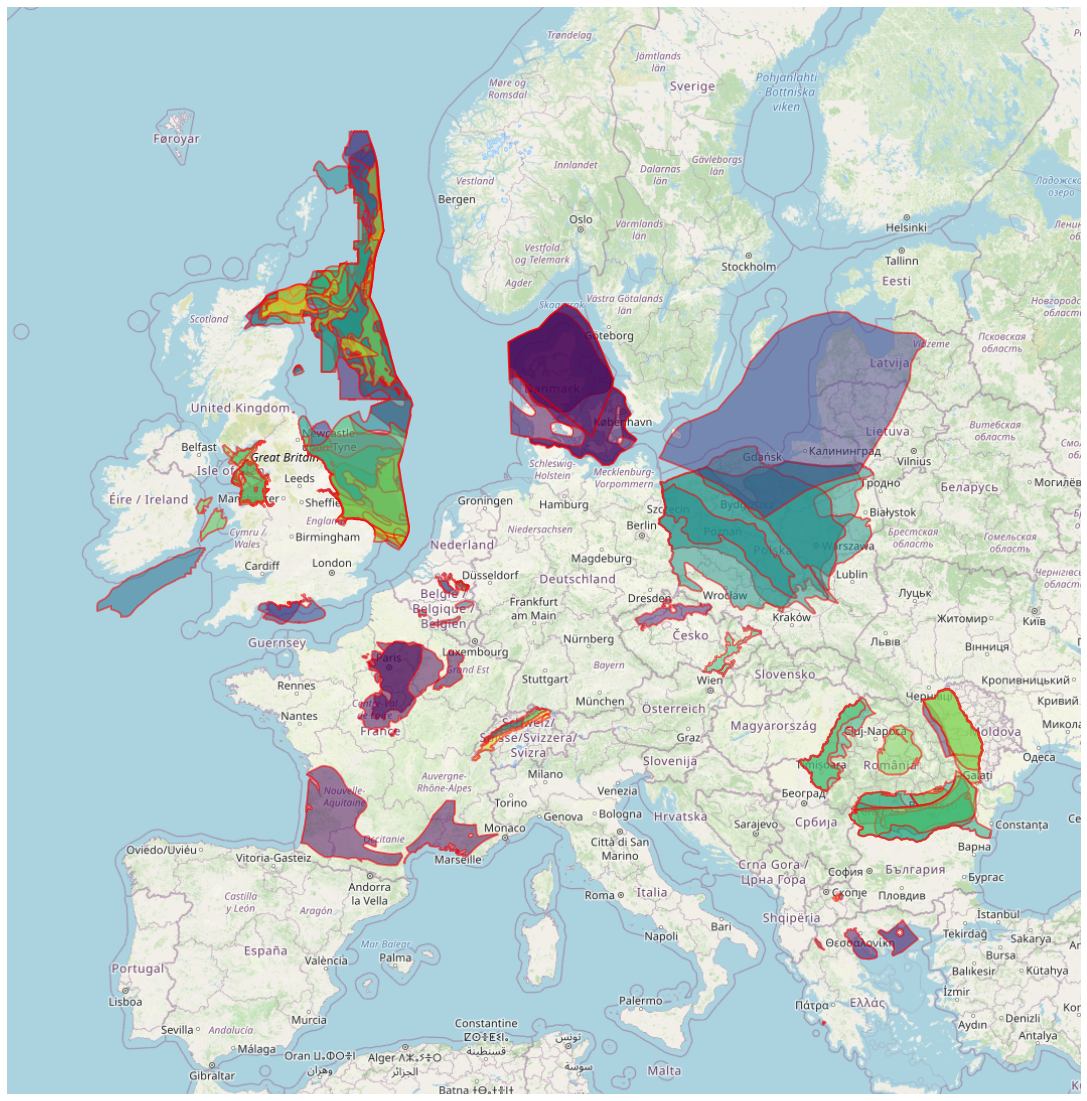

In [245]:
#StorerUnits 
Storeunit = gpd.read_file('Formations2_March12.kml', driver='KML')

eu=gpd.read_file('../country_shapes.geojson')
ax = geoplot.webmap(eu,projection=gcrs.WebMercator(),figsize=(30,20),alpha=1)
geoplot.choropleth(Storeunit, hue='Name',ax=ax,alpha=0.5,edgecolor='red', linewidth=2)

<GeoAxesSubplot:>

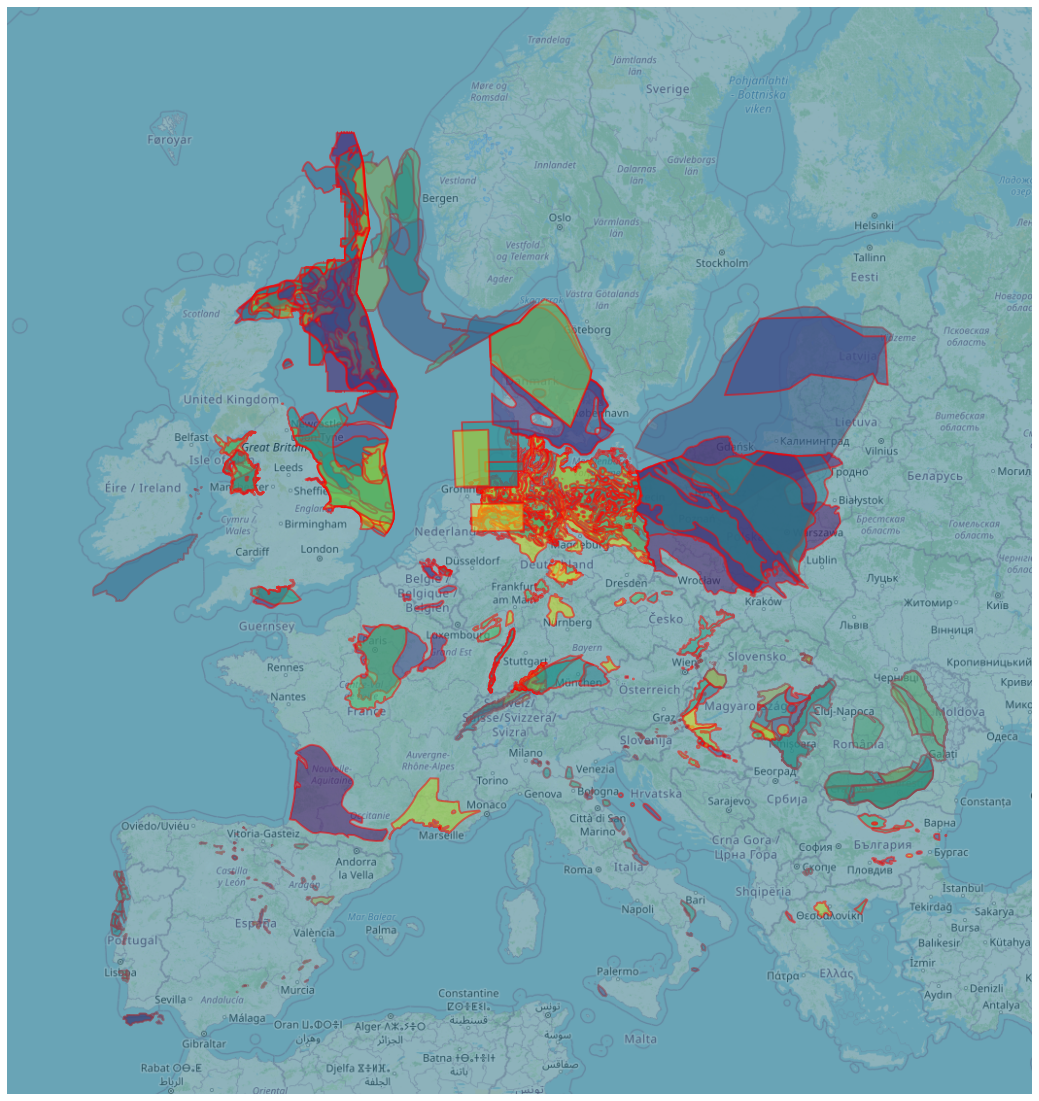

In [243]:
#StorerUnits 
Storeunit = gpd.read_file('StorageUnits_March13.kml', driver='KML')

eu=gpd.read_file('../country_shapes.geojson')
ax = geoplot.webmap(eu,projection=gcrs.WebMercator(),figsize=(30,20),alpha=1)
geoplot.choropleth(Storeunit, hue='Name',ax=ax,alpha=0.5,edgecolor='red', linewidth=2)

<GeoAxesSubplot:>

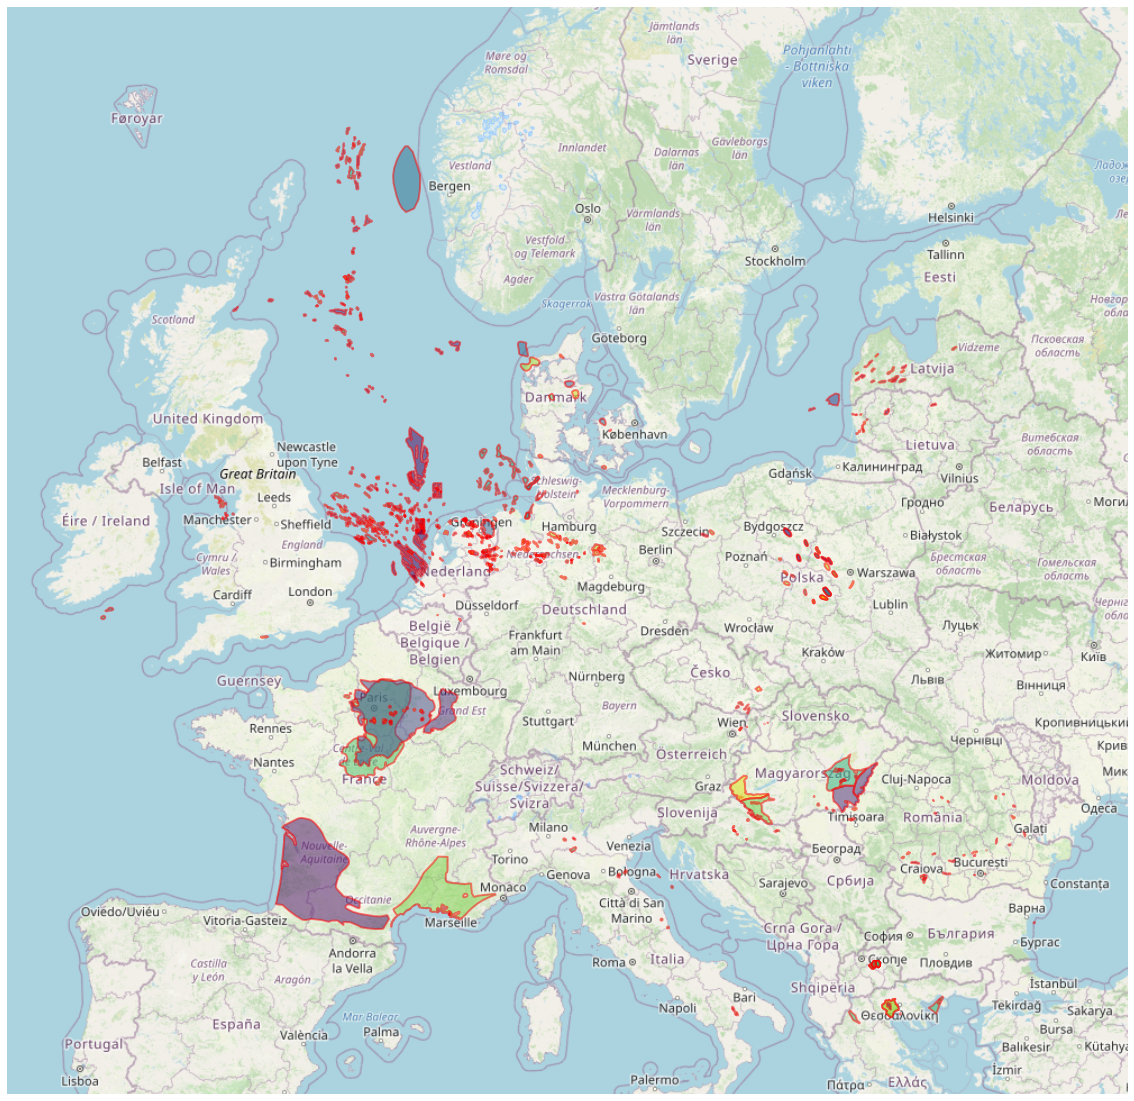

In [244]:
#DaughterUnits 
DaughterUnits = gpd.read_file('DaughterUnits_March13.kml', driver='KML')

eu=gpd.read_file('../country_shapes.geojson')
ax = geoplot.webmap(eu,projection=gcrs.WebMercator(),figsize=(30,20),alpha=1)
geoplot.choropleth(DaughterUnits, hue='Name',ax=ax,alpha=0.5,edgecolor='red', linewidth=2)

# Matching percentage:

In [251]:
#storeunit
namestore = set(Storeunit.Name)
namek = set(storage_unit.STORAGE_UNIT_NAME)
len(namestore-namek)/len(namestore)
# there are many name can be matched if we use re expression

0.7766990291262136

In [252]:
#daughterunit
named = set(DaughterUnits.Name)
namet = set(trap_all.TRAP_NAME)
len(named-namet)/len(named)

0.4933993399339934

In [ ]:
#import pycountry
code = pycountry.countries.search_fuzzy('IT')[0].alpha_2
storage_unit[storage_unit['COUNTRYCODE']==code]